t-SNE is another dimensionality reduction technique on par with PCA, although it yeilds a **visually** better 2d representation of highly dimensional and **non-linear** data (with less entropy) compared to first two components of the PCA.

We can visually verify that by plotting t-SNE and first two PCA components on the 64-pixel MNIST dataset from scikit-learn. First we load up the dataset as a set of points of 64 features:

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
import pandas as pd
from sklearn.decomposition import PCA

ds = load_digits()
ds.data.shape
df = pd.DataFrame(np.hstack([ds.data,ds.target.reshape(-1,1)]),
                  columns=ds.feature_names+['label'])
df.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4.0


Then plot first two PCA components:

In [28]:
import plotly.express as px
pca = PCA(.2)
x_pca = pca.fit_transform(df.drop(columns=['label']).values)
df_pca = pd.DataFrame(np.hstack([x_pca,ds.target.reshape(-1,1)]),
                  columns=['lamb1','lamb2']+['label'])
px.scatter(df_pca,'lamb1','lamb2','label')

While the PCA is able to give a general perspective on the entropy of the data, t-SNE is able to differentiate between different types of data better and is able to represent highly dimensional data in a more meaningful way:

In [30]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                init='random', perplexity=3).fit_transform(
                    df.drop(columns=['label']).values)
df_tsne = pd.DataFrame(np.hstack([X_embedded,ds.target.reshape(-1,1)]),
                  columns=['lamb1','lamb2']+['label'])
px.scatter(df_tsne,'lamb1','lamb2','label')

PCA is searching for largest eigenvalues of the covariance matrix (i.e. looking for more impactful **linear** transformations), which is quite a constrained approach, as it will yeild wrong results when the data distribution is complex. 

A good example is a swiss-roll dataset, with values decreasing along a complex shape, but the PCA would treat a plane that moves through the swiss roll a more impactful eigenvector. However, a more meaningful representation of this dataset would be in a cluster-like form, with clusters situated along the complex shape:

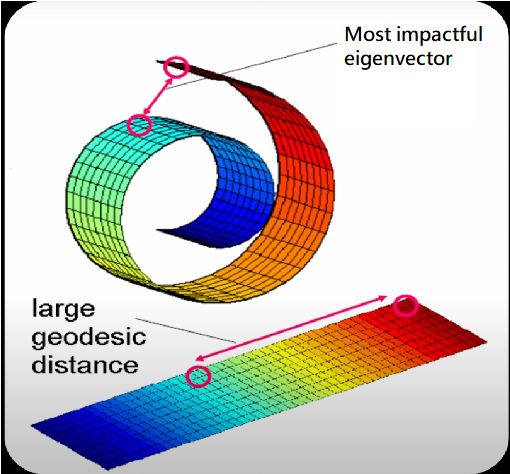

#### How does t-SNE achieves all that?
To answer this question, it's first important to have a look at the original SNE algorithm:
* randomly select $i$ points. We can choose them randomly or through PCA components
* we calculate pair-wise Euclidean distances between all points and randomly selected ones: $dist_{ij}$
* map point-wise distances onto the probability distribution using the formula (that is derived from the PDF of the normal distribution with the $\mu=0$, since $dist_{ii}=0$): $P(j|i)=\frac{exp(dist_{ji}/2\sigma_i^2)}{\sum_{k\neq i} exp(dist_{ji}/2\sigma_i^2)}$. The whole denominator/nominator idea is derived from the definition of the conditional probability: $P(A|B)=\frac{P(A\cap B)}{P(B)}$
*  Introduce $perplexity=e^{\overline{NLL}}$, where $NLL$ - is the negative log-likelihood
* We then try finding the best $\sigma_i$ for each random point by performing a binary search on some linear space of $\sigma\in[0.1,...,1]$ that satisfies a chosen general perplexity 
* Then we start removing dimensions and repeating all steps in a way that minimizes a difference between the original, highly dimensional distribution, and the new, of fewer dimensions. For calculating the difference between two distributions we use KL-divergence: $\sum_i\sum_j P(j|i)log\frac{P(j|i)}{Q(j|i)}$
* To compare quality of our fit we can also use a Shepard diagram, that plots distances of the distribution with higher dimensions against the distribution of fewer dimensions:

    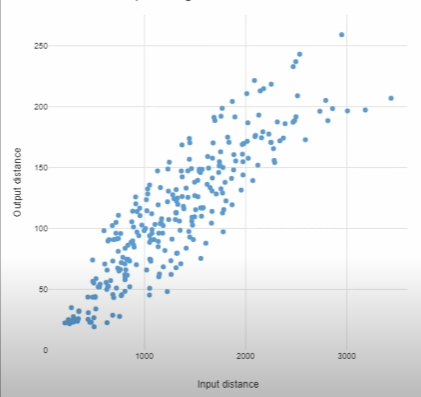